In [2]:
import pydicom
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
import pandas as pd
from imgaug import augmenters as iaa
from tqdm import tqdm
from joblib import Parallel, delayed

In [3]:
imgs = glob.glob("data/all/*")
print(len(imgs))

26684


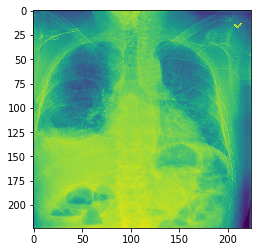

In [44]:
plt.imshow(np.array(Image.fromarray(ds.pixel_array).resize((224,224))).reshape(224,224,1).reshape(224,224))

In [15]:
def process(img):
    ds = pydicom.dcmread(img)
    image = Image.fromarray(ds.pixel_array).convert("RGB").resize((512,512))
    image.save(img.replace("all", "all_rgb").replace(".dcm", ".png"))

In [ ]:
results = Parallel(n_jobs=25)(delayed(process)(x) for x in tqdm(imgs))

 41%|████      | 10895/26684 [00:43<01:03, 246.76it/s]

In [3]:
df = pd.read_csv("all_data.csv")

In [4]:
df["Target"].value_counts()

0    20672
1     6012
Name: Target, dtype: int64

In [5]:
len(df)

26684

### AUgmengation

In [17]:
def heavy_augmentation(img):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5), # horizontally flip 50% of all images
            iaa.Flipud(0.2), # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}, # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10), # rotate by -45 to +45 degrees
                shear=(-5, 5) # shear by -16 to +16 degrees
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)), # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)), # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)), # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5), # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5), # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True), # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)), # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq.augment_image(img)

In [18]:
img = Image.fromarray(ds.pixel_array).resize((512,512))

In [26]:
# plt.imshow(heavy_augmentation(np.array(img,dtype=np.uint8)))

In [41]:
ds = pydicom.dcmread(i)

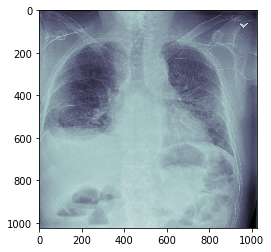

In [3]:
for i in imgs[10:20]:
    ds = pydicom.dcmread(i)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 
    plt.show()
    break